# Tests a network

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_TILES, TRAIN_LABEL_TILES, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels

In [4]:
import cv2

### Input data

Images of shape (512, 512, 17) 

In [5]:
from unet import unet_zero

Using Theano backend.


In [6]:
# RESIZE_TILES = False
# # tile_size = (512, 512)
# tile_size = (128, 128)
# n_channels = 17
# model = unet_zero(len(LABELS)-1, n_channels, *tile_size)

In [7]:
for i, l in enumerate(LABELS[1:]):
    print i, l

0 Buildings
1 Misc. Manmade structures
2 Road
3 Track
4 Trees
5 Crops
6 Waterway
7 Standing water
8 Vehicle Large
9 Vehicle Small


In [8]:
RESIZE_TILES = True
tile_size = (128, 128)
channels = np.array(range(11))
n_channels = len(channels)
labels = np.array(range(len(LABELS)))
n_labels = len(labels)

model = unet_zero(n_labels, n_channels, *tile_size)

In [9]:
channels, labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 11, 128, 128)  0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 128, 128)  3200        input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 128, 128)  9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 64, 64)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [11]:
import os
from keras.optimizers import Adam, Nadam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

In [12]:
from glob import glob
all_train_tiles = glob(os.path.join(TRAIN_TILES, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_TILES)+1:] for s in all_train_tiles])

In [13]:
all_train_tiles[0]

'6010_1_2_-64_-64.tif'

In [14]:
from sklearn.model_selection import train_test_split 

# TRAIN ON 128 TILES
# train_tiles, val_tiles = train_test_split(all_train_tiles[:128], test_size=0.3)

train_tiles, val_tiles = train_test_split(all_train_tiles, test_size=0.3)
print len(train_tiles), len(val_tiles)

1120 480


In [15]:
def normalize_image(img_data, max_value=1.0):
    if RESIZE_TILES:
        out = cv2.resize(img_data, dsize=tile_size, interpolation=cv2.INTER_CUBIC).astype(np.float32)
        if len(out.shape) == 2:
            out = out[:, :, None]
    else:
        out = img_data.astype(np.float32)

#     if max_value > 1.0:
#         out *= 1.0/max_value    
    if max_value > 1.0:  
        out = normalize(out, 0.01, 99.9)        
    
    out = out.transpose([2,0,1])
    return out


def generate_images(train_tiles, batch_size):
    while True:
        n = len(train_tiles)
        n_batches = n // batch_size
        random_indices = np.arange(n)
        np.random.shuffle(random_indices)
        for i in range(n_batches):
            end = min((i+1)*batch_size, n) 
            batch_indices = random_indices[batch_size*i:end]
            X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
            Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
            for j, tile_id in enumerate(train_tiles[batch_indices]):
                x = get_image_tile_data(os.path.join(TRAIN_TILES,tile_id))
                y = get_image_tile_data(os.path.join(TRAIN_LABEL_TILES,tile_id))

                if n_labels < len(LABELS) - 1:
                    y = y[:,:,labels]
                if n_channels < 17:
                    x = x[:,:,channels]

                x = normalize_image(x, 2.0**10)
                y = normalize_image(y)     
                
                X[j,:,:,:] = x
                Y[j,:,:,:] = y 
                
            yield (X, Y)

(5, 11, 128, 128) (5, 11, 128, 128)
0.0 1.0 0.0 255.0


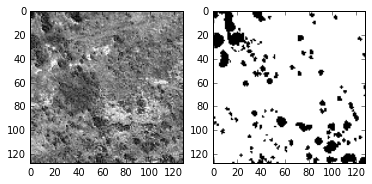

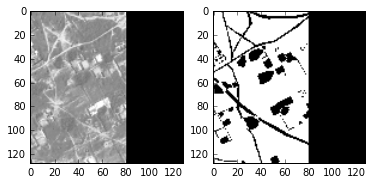

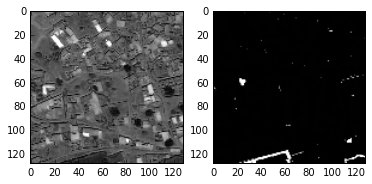

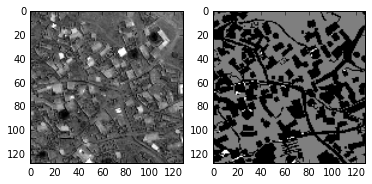

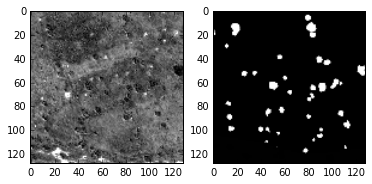

In [16]:
batch_size = 5
for X, Y in generate_images(train_tiles, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        plt.figure()
        plt.subplot(121)
        display_img_1b(X[i,1,:,:])
        plt.subplot(122)
        display_img_1b(Y[i,0,:,:])
    break

In [17]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint('weights/unet_zero.h5', monitor='loss', save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

# LearningRateScheduler

In [18]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [19]:
foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 8
samples_per_epoch = foo(len(train_tiles))
nb_val_samples = foo(len(val_tiles))


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_tiles, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=150,
    validation_data=generate_images(val_tiles, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=1
)

8 112 80
Epoch 1/150
112/112 [==============================] - 80s - loss: 406.9075 - jaccard_coef: 3.9815e-06 - jaccard_coef_int: 4.6583e-13 - acc: 0.2340 - val_loss: 365.8715 - val_jaccard_coef: 4.0030e-06 - val_jaccard_coef_int: 5.3304e-13 - val_acc: 0.1763
Epoch 2/150
112/112 [==============================] - 74s - loss: 345.5782 - jaccard_coef: 5.1461e-06 - jaccard_coef_int: 4.8271e-11 - acc: 0.1853 - val_loss: 367.1746 - val_jaccard_coef: 1.0030e-05 - val_jaccard_coef_int: 1.7031e-12 - val_acc: 0.1517
Epoch 3/150
112/112 [==============================] - 72s - loss: 370.5267 - jaccard_coef: 7.4492e-06 - jaccard_coef_int: 3.2092e-12 - acc: 0.1398 - val_loss: 295.6981 - val_jaccard_coef: 3.7473e-06 - val_jaccard_coef_int: 7.2899e-13 - val_acc: 0.1488
Epoch 4/150
112/112 [==============================] - 73s - loss: 253.3452 - jaccard_coef: 4.5758e-06 - jaccard_coef_int: 5.7267e-13 - acc: 0.1358 - val_loss: 274.3397 - val_jaccard_coef: 4.5923e-06 - val_jaccard_coef_int: 6.6228e-

KeyboardInterrupt: 

In [33]:
plt.plot(history.history['val_jaccard_coef_int'])
plt.ylabel('Jaccard coeff integer')
# plt.plot(history.history['val_jaccard_coef'])
# plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [20]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5, 11, 128, 128) 7.56982e-22 0.000444466


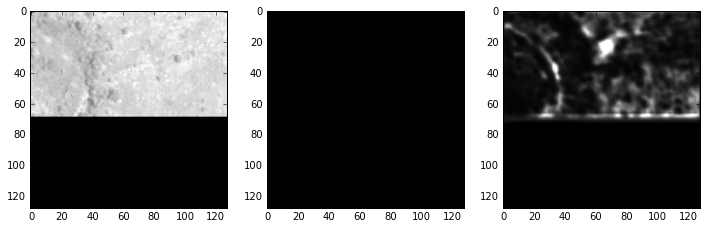

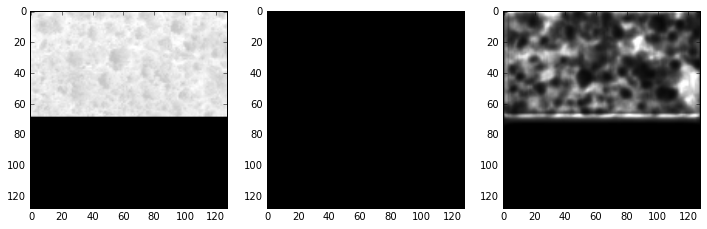

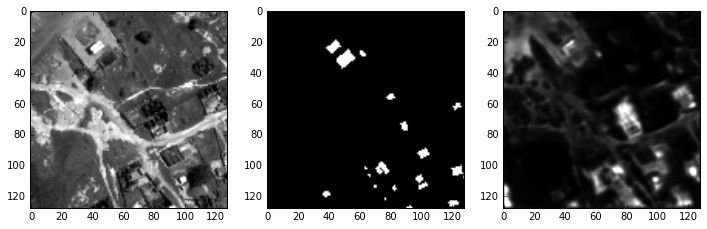

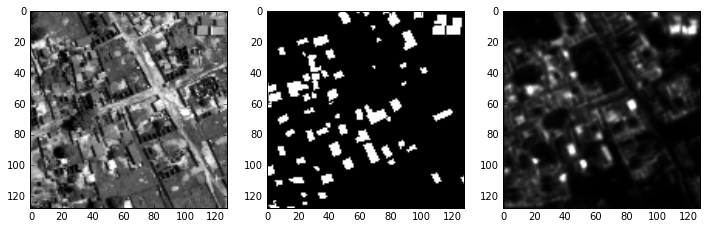

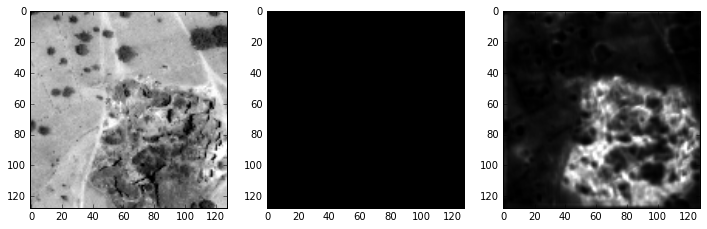

In [21]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

    for i in range(batch_size):
        _plot(X, Y, Y_pred, i)

#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)
    break


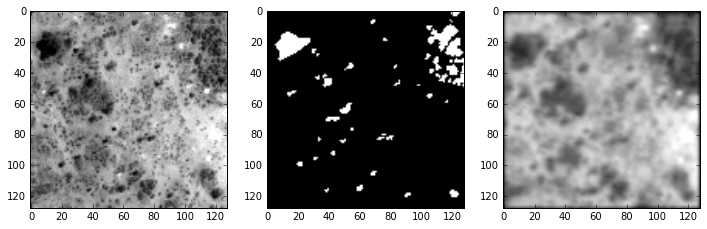

In [42]:
_plot(X, Y, Y_pred, 0, 0)

In [22]:
y = Y_pred[0,1,:,:]
print y.min(), y.max()

2.11063e-12 0.000444466
